# Data Preparation

## Loading the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
import numpy as np

X = mnist.data
y = mnist.target.astype(np.uint8)

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
# setting aside 10_000 examples for testing
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## Getting the Data ready to train the model using data augmentation

In [7]:
import matplotlib.pyplot as plt

def plot_digit(digit_aray):
    # a function for plotting the digit given it's array
    plt.imshow(digit_aray.reshape(28, 28), cmap="binary")
    plt.axis("off")
    plt.show()

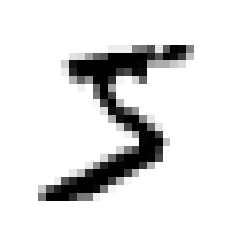

In [8]:
plot_digit(digit_aray=X_train[0])

In [9]:
import numpy as np

def switch_colors(digit_array):
    # function for changing all white colors to black and black colors to white
    return (np.full(len(digit_array), 255, dtype=int) - digit_array)


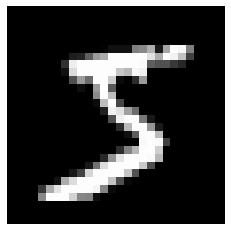

In [10]:
plot_digit(switch_colors(X_train[0]))

In [11]:
import numpy as np

def add_noise(digit_array, noise_intensity=1):
    # function for adding noise to the digits
    if 0 < noise_intensity <= 16:
        noise = noise_intensity * np.random.randint(5, 15, len(digit_array))
        return noise + digit_array
    # in case the noise intensity is not ranging from 1 to 16.
    else:
        raise ValueError("noise_intensity has to range from 1 to 16.")

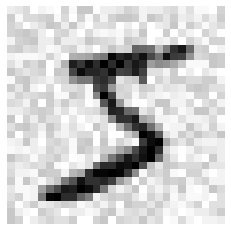

In [12]:
plot_digit(add_noise(X_train[0], noise_intensity=8))

In [13]:
from scipy.ndimage.interpolation import shift

def make_shift(digit_array, units_to_shift):
    # the numbers won't always be exactly in the middle of the image. shifted imgs will account for that
    digit_image = np.reshape(digit_array, (28, 28))
    shifted_digit = shift(digit_image, units_to_shift)
    return shifted_digit.reshape(784)

## Creating Some Useful Functions

In [14]:
import os
import pickle

def save_model(model):
    directory_name = "saved_models"
    # incase the directory doesn't exist
    os.makedirs(directory_name, exist_ok=True)

    # getting all the file names in the directory
    all_model_names = [name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))]

    current_model_name = "01_current_model.pkl"

    # if there's a current model, we need to rename it.
    if current_model_name in all_model_names:
        model_number = len(all_model_names)
        old_name = os.path.join(directory_name, current_model_name)
        new_name = os.path.join(directory_name, f"model_{model_number}.pkl")
        os.rename(old_name, new_name)
        print(f"Previous model renamed from {old_name} to {new_name}")

    
    with open(os.path.join(directory_name, current_model_name), "wb") as f:
        pickle.dump(model, f)
    
    print(f"New model saved: {directory_name}\{current_model_name}")
        


In [15]:
import pickle
import os

def load_current_model():
    # som variables to use
    directory_name = "saved_models"
    current_model_name = "01_current_model.pkl"

    # in case no model has been saved before
    if os.path.isdir(directory_name):
        try:
            with open(os.path.join(directory_name, current_model_name), "rb") as f:
                return pickle.load(f)
        # in case it there's a problem when trying to laod the model from the file
        except Exception as e:
            print(e)
            print(f"Error while trying to load model '{os.path.join(directory_name, current_model_name)}'")
    # in case there is no saved model yet        
    else:
        raise FileNotFoundError(f"No such directory '.\\{directory_name}\\'")

## Getting Some data together

In [16]:
import numpy as np
# combining some training elements to use to fit model

X_train_noise = np.apply_along_axis(add_noise, 1, X_train, noise_intensity=8)
# y_train_noise = y_train.copy()

X_train_inverted = np.apply_along_axis(switch_colors, 1, X_train)
# y_train_inverted = y_train.copy()

X_train_noise_inverted = np. apply_along_axis(switch_colors, 1, X_train_noise)
# y_train_noise_inverted = y_train_noise.cop()

X_combined = np.concatenate(
    (X_train, X_train_noise, X_train_inverted, X_train_noise_inverted), 
    axis=0
)

y_combined = np.concatenate(
    (y_train, y_train, y_train, y_train), 
)

In [17]:
from sklearn.utils import shuffle

X_combined, y_combined = shuffle(X_combined, y_combined, random_state=44)

In [18]:
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(X_combined, y_combined, test_size=0.1, random_state=44)

## Training Model

### Training KNClassifier with default parameters

In [19]:
from sklearn.neighbors import KNeighborsClassifier

kn_classifier = KNeighborsClassifier()

In [20]:
# kn_classifier.fit(X_train_final, y_train_final)

In [21]:
# kn_classifier.score(X_val, y_val)

In [22]:
# saving the model
# save_model(kn_classifier)

Previous model renamed from saved_models\01_current_model.pkl to saved_models\model_2.pkl
New model saved: saved_models\01_current_model.pkl


### Training and SVC with default parameters on the final dataset and saving it

In [23]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# adding a scaler to scale down the input values before passing them to the SVC
sv_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("sv_classifier", SVC()),
])

In [24]:
# training the model
sv_pipeline.fit(X_train_final, y_train_final)

Pipeline(steps=[('scaler', StandardScaler()), ('sv_classifier', SVC())])

In [25]:
# scoring the SVC on the validation set
sv_pipeline.score(X_val, y_val)

0.97475

In [26]:
# saving the SVC
save_model(sv_pipeline)

Previous model renamed from saved_models\01_current_model.pkl to saved_models\model_3.pkl
New model saved: saved_models\01_current_model.pkl
